Populating the interactive namespace from numpy and matplotlib


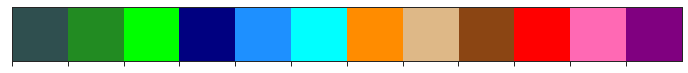

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
palette=['#2f4f4f','#228b22','#00ff00','#000080','#1e90ff','#00ffff','#ff8c00','#deb887','#8b4513','#ff0000','#ff69b4','#800080',]
sns.palplot(palette)

In [2]:
from scipy.stats import chi2

In [3]:
def save_fig(filename, fig=None):
    if fig is None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    else:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        
def plot_scatter_comparison(df, col, lim, color='#deb887'):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=df, x=col, y=col+'_final', color=color)
    plt.plot(lim, lim, 'k--')
    plt.xlim(lim)
    plt.ylim(lim)
    
def plot_kde_comparison(df, col, lim, color='#8b4513'):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.kdeplot(data=df, x=col, y=col+'_final', color=color)
    plt.plot(lim, lim, 'k--')
    plt.xlim(lim)
    plt.ylim(lim)
    
def plot_dis_comparison(df, col, lim, color='#deb887'):
    # fig, ax = plt.subplots(figsize=(6,6))
    sns.displot(data=df, x=col, y=col+'_final', color=color)
    plt.plot(lim, lim, 'k--')
    plt.xlim(lim)
    plt.ylim(lim)
    
def filter_variant_table(df, variant_filter):
    filtered_df = df.query(variant_filter)
    print('%.2f%% variants passed the filter' % (100 * len(filtered_df) / len(df)))
    return filtered_df

def plot_rep_comparison(r1, r2, param, lim, add_final=True, color='#deb887'):
    if add_final:
        col = param + '_final'
    else:
        col = param
        
    df = r1[['SEQID', col]].merge(r2[['SEQID', col]], on='SEQID')
    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(lim, lim, '--', c='gray')
    sns.kdeplot(data=df, x=col+'_x', y=col+'_y', color=color)    
    plt.xlim(lim)
    plt.ylim(lim)    
    plt.xlabel('r1')
    plt.ylabel('r2')
    plt.title(param)
    
def get_dG(dH, Tm, t):
    return dH * (1 - (273.15 + t) / Tm)
    
def get_dof(row):
    n_T = len(np.arange(20, 62.5, 2.5))
    dof = row['n_clusters'] * n_T - 4 + row['enforce_fmax'] + row['enforce_fmin']
    return dof

def get_chi2(row):
    return row['dof'] * row['chisq']

def pass_chi2(row):
    cutoff = chi2.ppf(q=.99, df=row['dof'])
    return row['chi2'] < cutoff

def add_dG_chi2_test(df):
    df['dof'] = df.apply(get_dof, axis=1)
    df['chi2'] = df.apply(get_chi2, axis=1)
    df['pass_chi2'] = df.apply(pass_chi2, axis=1)
    
    n_pass = sum(df['pass_chi2'])
    print('%d / %d, %.2f%% varaints passed the chi2 test' % (n_pass, len(df), 100 * n_pass / len(df)))
    
    df['dG_37_final'] = get_dG(df['dH_final'], df['Tm_final'], t=37)
    df['dG_37_ub_final'] = get_dG(df['dH_ub_final'], df['Tm_lb_final'], t=37)
    df['dG_37_lb_final'] = get_dG(df['dH_lb_final'], df['Tm_ub_final'], t=37)

    return df

In [4]:
lib2b_r1 = pd.read_csv('/Users/yuxi/workspace/nnn/data/fitted_variant/NNNlib2b_DNA_20211022_v5.CPvariant.gz', sep='\t')
lib2b_r1.rename(columns={'chisquared_all_clusters': 'chisq'}, inplace=True)
lib2b_r2 = pd.read_csv('/Users/yuxi/workspace/nnn/data/fitted_variant/NNNlib2b_DNA_20211221.CPvariant.gz', sep='\t')

In [5]:
annotation = pd.read_csv('/Users/yuxi/workspace/nnn/data/annotation/NNNlib2b_annotation_nupack.txt', sep='\t').set_index('SEQID')

In [6]:
variant_filter = "rsqr_final > 0.5 & fmin_final > -1 & fmin_final < 2 & fmax_final > 0 & fmax_final < 3 & dH_final > -400 & chisq < 2 & n_clusters > 20 & dH_std_final < 50 & Tm_std_final < 15"
lib2b_r1 = filter_variant_table(lib2b_r1, variant_filter)
lib2b_r2 = filter_variant_table(lib2b_r2, variant_filter)

84.91% variants passed the filter
81.73% variants passed the filter


In [7]:
lib2b_r1 = add_dG_chi2_test(lib2b_r1).set_index('SEQID')
lib2b_r2 = add_dG_chi2_test(lib2b_r2).set_index('SEQID')

26805 / 27492, 97.50% varaints passed the chi2 test
23486 / 23501, 99.94% varaints passed the chi2 test


In [8]:
lib2b_r1.columns

Index(['Green14_20_norm', 'Green14_20_norm_std', 'Green15_22.5_norm',
       'Green15_22.5_norm_std', 'Green16_25_norm', 'Green16_25_norm_std',
       'Green17_27.5_norm', 'Green17_27.5_norm_std', 'Green18_30_norm',
       'Green18_30_norm_std', 'Green19_32.5_norm', 'Green19_32.5_norm_std',
       'Green20_35_norm', 'Green20_35_norm_std', 'Green21_37.5_norm',
       'Green21_37.5_norm_std', 'Green22_40_norm', 'Green22_40_norm_std',
       'Green23_42.5_norm', 'Green23_42.5_norm_std', 'Green24_45_norm',
       'Green24_45_norm_std', 'Green25_47.5_norm', 'Green25_47.5_norm_std',
       'Green26_50_norm', 'Green26_50_norm_std', 'Green27_52.5_norm',
       'Green27_52.5_norm_std', 'Green28_55_norm', 'Green28_55_norm_std',
       'Green29_57.5_norm', 'Green29_57.5_norm_std', 'Green30_60_norm',
       'Green30_60_norm_std', 'RMSE_final', 'Tm_final', 'Tm_lb_final',
       'Tm_std_final', 'Tm_ub_final', 'chisq', 'chisquared_of_median',
       'dH_final', 'dH_lb_final', 'dH_std_final', 'dH_ub_f

# Figure 1

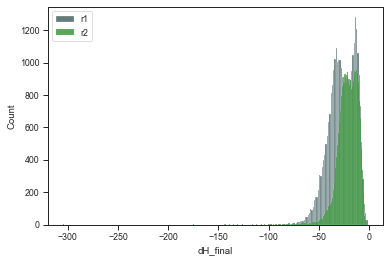

In [51]:
sns.histplot(lib2b_r1.dH_final, color=palette[0])
sns.histplot(lib2b_r2.dH_final, color=palette[1])
# plt.xlim([0.8,1.2])
plt.legend(['r1', 'r2'])

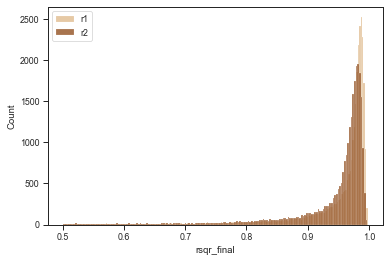

In [80]:
sns.histplot(lib2b_r1.rsqr_final, color=palette[7])
sns.histplot(lib2b_r2.rsqr_final, color=palette[8])
# plt.xlim([0.8,1.2])
plt.legend(['r1', 'r2'])

In [68]:
lib2b_r1.Tm_final

0        340.719903
1        315.697239
2        308.459413
3        337.688204
4        318.423686
            ...    
32373    328.895868
32374    330.354373
32376    310.086823
32377    318.736525
32378    290.989540
Name: Tm_final, Length: 29897, dtype: float64

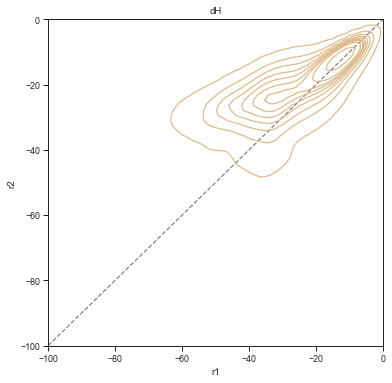

In [74]:
plot_rep_comparison(lib2b_r1, lib2b_r2, param='dH', lim=[-100, 0])

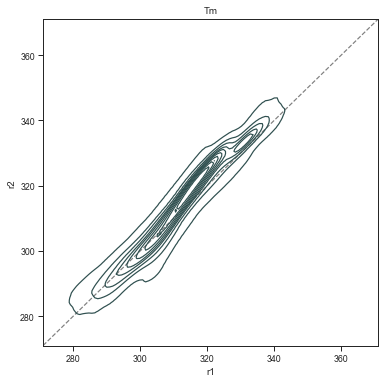

In [75]:
plot_rep_comparison(lib2b_r1, lib2b_r2, param='Tm', lim=[271, 371], color=palette[0])

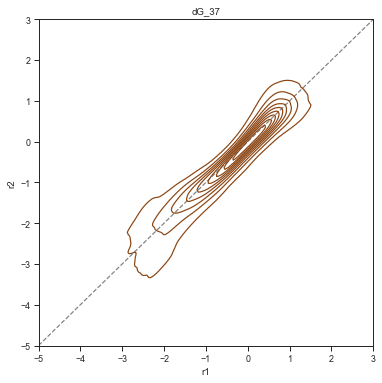

In [437]:
plot_rep_comparison(lib2b_r1.reset_index(), lib2b_r2.reset_index(), param='dG_37', lim=[-5, 3], color=palette[8])
save_fig('./fig/rep_dG_37.pdf')

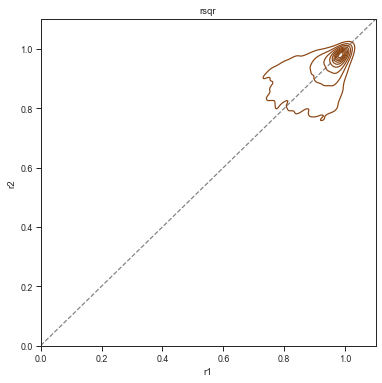

In [78]:
plot_rep_comparison(lib2b_r1, lib2b_r2, param='rsqr', lim=[0,1.1], color=palette[8])

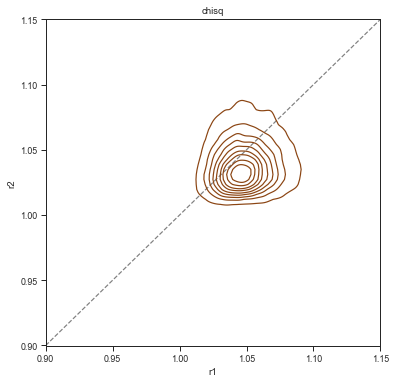

In [84]:
plot_rep_comparison(lib2b_r1, lib2b_r2, param='chisq', add_final=False, lim=[.9,1.15], color=palette[8])

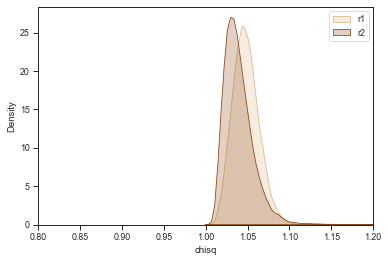

In [99]:
# sns.scatterplot(lib2b_r1.chisq, lib2b_r2.chisq)
sns.kdeplot(lib2b_r1.chisq, fill=True, color=palette[7])
sns.kdeplot(lib2b_r2.chisq, fill=True, color=palette[8])
plt.xlim([.8, 1.2])
plt.legend(['r1', 'r2'])

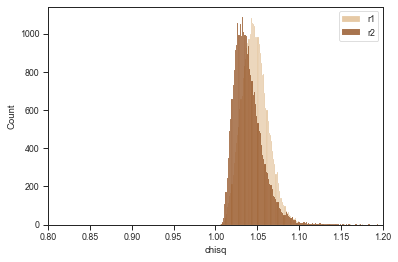

In [85]:
# sns.scatterplot(lib2b_r1.chisq, lib2b_r2.chisq)
sns.histplot(lib2b_r1.chisq, color=palette[7])
sns.histplot(lib2b_r2.chisq, color=palette[8])
plt.xlim([0.8,1.2])
plt.legend(['r1', 'r2'])

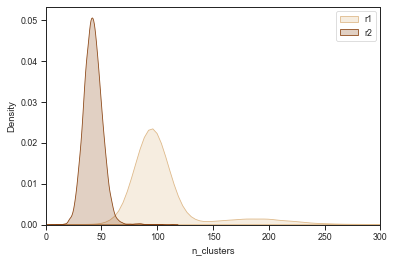

In [97]:
# sns.scatterplot(lib2b_r1.chisq, lib2b_r2.chisq)
sns.kdeplot(lib2b_r1.n_clusters, fill=True, color=palette[7])
sns.kdeplot(lib2b_r2.n_clusters, fill=True, color=palette[8])
plt.xlim([0,300])
plt.legend(['r1', 'r2'])

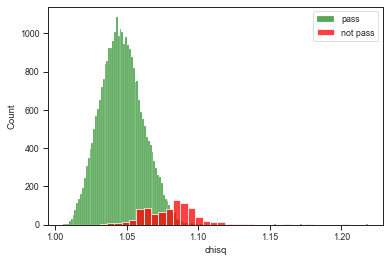

In [166]:
sns.histplot(lib2b_r1.query('pass_chi2').chisq, color=palette[1])
sns.histplot(lib2b_r1.query('not pass_chi2').chisq, color=palette[9])
plt.legend(['pass', 'not pass'])

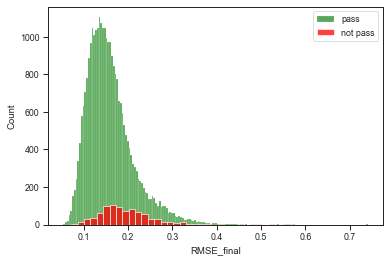

In [168]:
sns.histplot(lib2b_r1.query('pass_chi2').RMSE_final, color=palette[1])
sns.histplot(lib2b_r1.query('not pass_chi2').RMSE_final, color=palette[9])
plt.legend(['pass', 'not pass'])

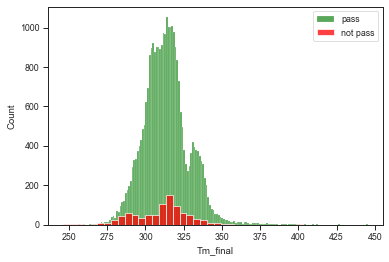

In [170]:
sns.histplot(lib2b_r1.query('pass_chi2').Tm_final, color=palette[1])
sns.histplot(lib2b_r1.query('not pass_chi2').Tm_final, color=palette[9])
plt.legend(['pass', 'not pass'])

In [207]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'browser'

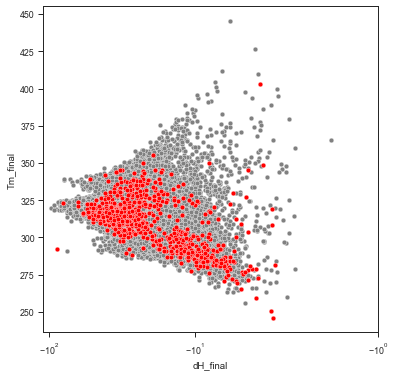

In [210]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=lib2b_r1.query('pass_chi2'), x='dH_final', y='Tm_final', color='gray')
sns.scatterplot(data=lib2b_r1.query('not pass_chi2'), x='dH_final', y='Tm_final', color='r')
plt.xlim([-110, -1])
plt.xscale('symlog')

In [213]:
fig = px.scatter(lib2b_r1, x='dH_final', y='Tm_final', color='RMSE_final',
                 hover_data=['SEQID', 'n_clusters', 'RMSE_final'],
                 width=1200, height=1000,# range_color=[273,373],
                 title='')
fig.show()

In [231]:
def plot_actual_and_expected_fit(row, ax, errorbar=True, c='k', ylim=None):
    function = lambda dH, Tm, fmax, fmin, x: (fmax - fmin) / (1 + np.exp(dH/0.00198*(Tm**-1 - x))) + fmin

    conds = [x for x in row.keys() if x.endswith('_norm')]
    errs = [x for x in row.keys() if x.endswith('_norm_std')]

    vals = np.array(row[conds].values,dtype=float) 
    errors = np.array(row[errs].values,dtype=float)

    T_celsius=[20,22.5,25,27.5,30,32.5,35,37.5,40,42.5,45,47.5,50,52.5,55,57.5,60]
    T_kelvin=[x+273.15 for x in T_celsius]
    T_inv = np.array([1/x for x in T_kelvin])
    
    pred_fit = function(row['dH_final'],row['Tm_final'],row['fmax_final'],row['fmin_final'],T_inv)
    
    xlim([18,62])
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim([-0.1,1.4])

    if errorbar:
        ax.errorbar(T_celsius, vals, yerr=errors,fmt='.',c=c)
    else:
        ax.plot(T_celsius, vals, '.', c=c)
    ax.plot(T_celsius, pred_fit, c=c, lw=3)

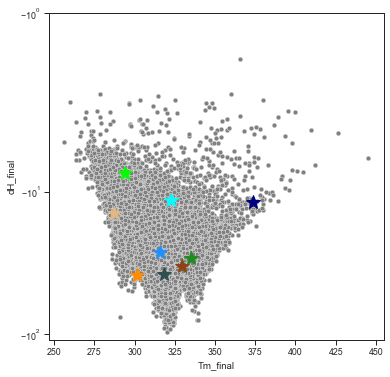

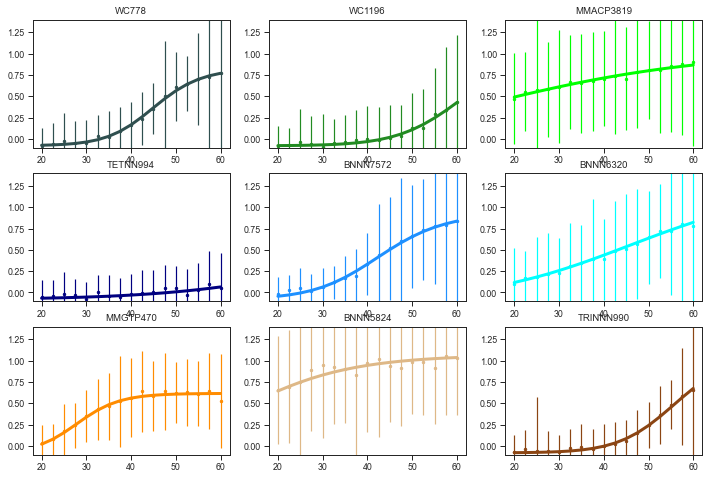

In [288]:
example_SEQID_list = ['WC778', 'WC1196', 'MMACP3819', 'TETNN994', 'BNNN7572', 'BNNN6320', 'MMGTP470', 'BNNN5824', 'TRINNN990']

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=lib2b_r1.query('pass_chi2'), x='Tm_final', y='dH_final', color='gray')
for i in range(len(example_SEQID_list)):
    datapoint = lib2b_r1.loc[example_SEQID_list[i],:]
    ax.plot([datapoint['Tm_final']], [datapoint['dH_final']], marker='*', markersize=15, color=palette[i])
# sns.scatterplot(data=lib2b_r1.query('not pass_chi2'), x='dH_final', y='Tm_final', color='r')
plt.ylim([-110, -1])
plt.yscale('symlog')
plt.show()

fig, ax = plt.subplots(3,3, figsize=(12,8))
ax = ax.flatten()

for i in range(len(example_SEQID_list)):
    plot_actual_and_expected_fit(lib2b_r1.loc[example_SEQID_list[i],:], ax[i], c=palette[i])
    ax[i].set_title(example_SEQID_list[i])
plt.show()


In [283]:
lib2b_r1['dH_bin'] = pd.cut(lib2b_r1.dH_final, 6)

(0.0, 50.0)

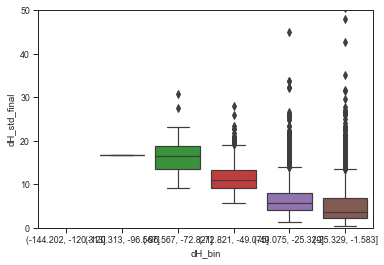

In [286]:
sns.boxplot(data=lib2b_r1, y='dH_std_final', x='dH_bin')
plt.ylim([0,50])

<AxesSubplot:xlabel='n_clusters', ylabel='Tm_std_final'>

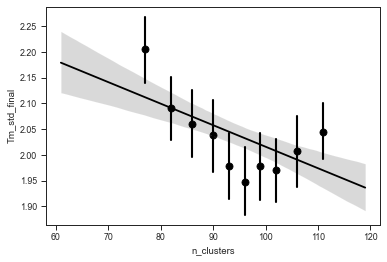

In [307]:
sns.regplot(data=lib2b_r1.query('n_clusters > 60 & n_clusters < 120'), x='n_clusters', y='Tm_std_final', x_bins=10, color='k')

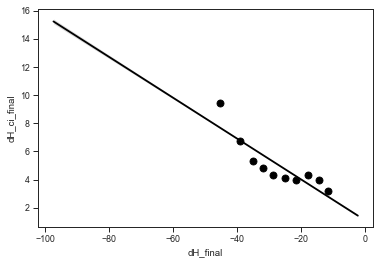

In [342]:

lib2b_r1['dH_ci_final'] = (lib2b_r1['dH_ub_final'] - lib2b_r1['dH_lb_final']) / 4
sns.regplot(data=lib2b_r1, x='dH_final', y='dH_ci_final', x_bins=10, color='k')
save_fig('./fig/n_clusters_vs_dH_std.pdf')

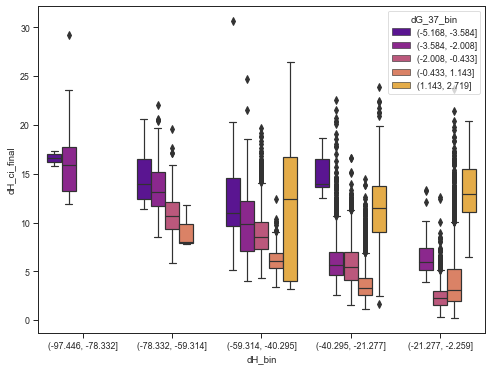

In [364]:
fig, ax = plt.subplots(figsize=(8,6))
lib2b_r1['dG_37_bin'] = pd.cut(lib2b_r1.dG_37_final, 5)
lib2b_r1['dH_bin'] = pd.cut(lib2b_r1.dH_final, 5)
lib2b_r1['dH_ci_final'] = (lib2b_r1['dH_ub_final'] - lib2b_r1['dH_lb_final']) / 4
sns.boxplot(data=lib2b_r1, hue='dG_37_bin', x='dH_bin', y='dH_ci_final', palette='plasma')
# plt.ylim([0,3])
save_fig('./fig/dG_37_vs_dG_37_err.pdf')

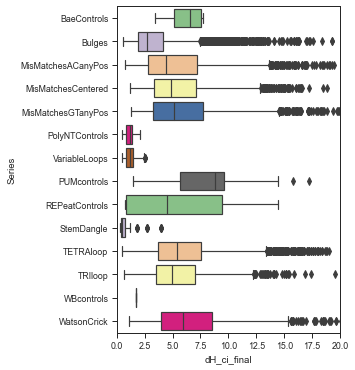

In [386]:
fig, ax = plt.subplots(figsize=(4,6))
sns.boxplot(data=df, y='Series', x='dH_ci_final', palette='Accent', orient='h')
plt.xlim([0,20])
save_fig('./fig/dH_err_per_series.pdf')

In [371]:
df = lib2b_r1.merge(annotation, on='SEQID')

/Users/yuxi/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='dG_37_ci_final', ylabel='Density'>

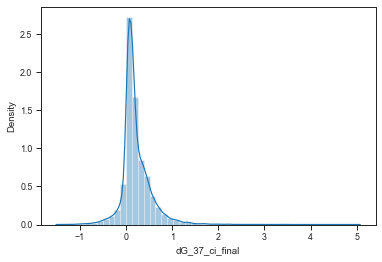

In [361]:
sns.distplot(lib2b_r1.dG_37_ci_final)

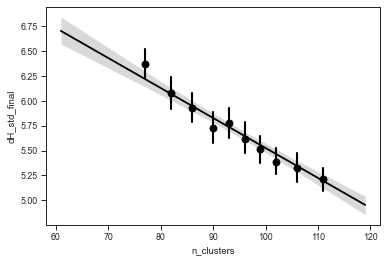

In [322]:
sns.regplot(data=lib2b_r1.query('n_clusters > 60 & n_clusters < 120'), x='n_clusters', y='dH_std_final', x_bins=10, color='k')
save_fig('./fig/n_clusters_vs_dH_std.pdf')

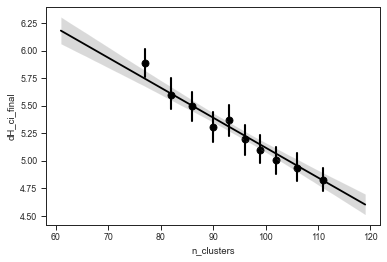

In [337]:

lib2b_r1['dH_ci_final'] = (lib2b_r1['dH_ub_final'] - lib2b_r1['dH_lb_final']) / 4
sns.regplot(data=lib2b_r1.query('n_clusters > 60 & n_clusters < 120'), x='n_clusters', y='dH_ci_final', x_bins=10, color='k')
save_fig('./fig/n_clusters_vs_dH_std.pdf')

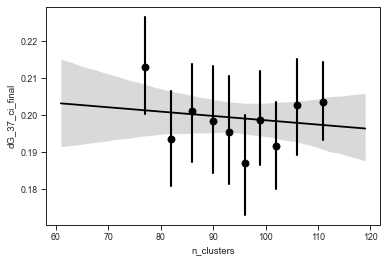

In [336]:

lib2b_r1['dG_37_ci_final'] = (lib2b_r1['dG_37_ub_final'] - lib2b_r1['dG_37_lb_final']) / 4
sns.regplot(data=lib2b_r1.query('n_clusters > 60 & n_clusters < 120'), x='n_clusters', y='dG_37_ci_final', x_bins=10, color='k')
save_fig('./fig/n_clusters_vs_dG_37_std.pdf')

/Users/yuxi/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Tm_std_final', ylabel='Density'>

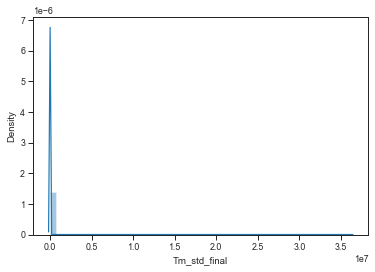

In [297]:
sns.distplot(lib2b_r1.Tm_std_final)

# Figure 2

In [430]:
r1 = lib2b_r1.reset_index().merge(annotation.reset_index().rename(columns={'dG_37C': 'dG_37'}), on='SEQID', how='left')

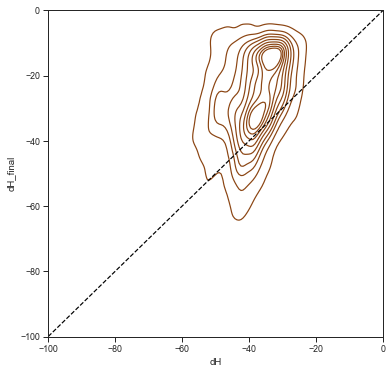

In [434]:
plot_kde_comparison(lib2b_r1.reset_index().merge(annotation.reset_index(), on='SEQID', how='left'), 'dH', lim=[-100,0])
save_fig('./fig/NUPACK_dH.pdf')

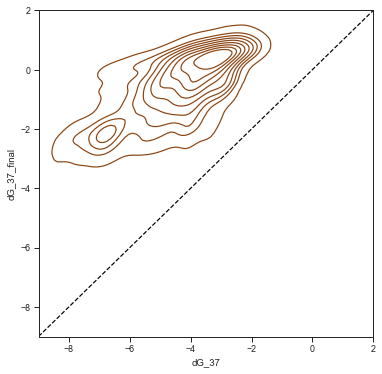

In [435]:
plot_kde_comparison(r1, 'dG_37', lim=[-9,2])
save_fig('./fig/NUPACK_dG_37.pdf')

In [388]:
np.unique(annotation.Series)

array(['BaeControls', 'Bulges', 'MisMatchesACanyPos',
       'MisMatchesCentered', 'MisMatchesGTanyPos', 'PUMcontrols',
       'PolyNTControls', 'PseudoKnots', 'REPeatControls', 'StemDangle',
       'SuperStem', 'TETRAloop', 'TRIloop', 'VariableLoops', 'WBcontrols',
       'WatsonCrick'], dtype=object)

In [390]:
annotation.query('Series == "MisMatchesCentered"')

,Series,ConstructType,Scaffold,Scaffoldposition,RefSeq,dH,dS,Tm,dG_37C
SEQID,,,,,,,,,
MMCNNN0,MisMatchesCentered,NNN,GCGC,Both,GAAAAACGAAAGTTATTC,-27.756879,-0.079935,74.093413,-2.705208
MMCNNN1,MisMatchesCentered,NNN,GCGC,Both,GAAAAACGAAAGTTCTTC,-24.759038,-0.071449,73.379555,-2.242004
MMCNNN2,MisMatchesCentered,NNN,GCGC,Both,GAAAAACGAAAGTTGTTC,-30.785304,-0.088719,73.846684,-2.991755
MMCNNN3,MisMatchesCentered,NNN,GCGC,Both,GAACAACGAAAGTTATTC,-25.408633,-0.073051,74.668254,-2.491422
MMCNNN4,MisMatchesCentered,NNN,GCGC,Both,GAACAACGAAAGTTCTTC,-25.954736,-0.075300,71.534764,-2.234224
...,...,...,...,...,...,...,...,...,...
MMCNN379,MisMatchesCentered,NN,GATCGATC,Both,GACTCTCGAAAGAGTGTC,-41.059929,-0.118384,73.686810,-4.178577
MMCNN380,MisMatchesCentered,NN,GATCGATC,Both,GACTCTCGAAAGAGGGTC,-35.390635,-0.099163,83.744176,-4.504800
MMCNN381,MisMatchesCentered,NN,GATCGATC,Both,GACGCTCGAAAGAGAGTC,-40.159521,-0.114856,76.500681,-4.387236
